# Primer - Find Important Wildfire Events 

### Load Libraries

Running python 3.7.7 on Mac OS

In [3]:
import json
import pandas as pd
import numpy as np
import string
from datetime import datetime
from tqdm import tqdm
import spacy
import re
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min


### Download spacy's en_core_web_lg model in terminal

In [4]:
#python -m spacy download en_core_web_lg

### Load and Analyze Data

In [5]:
#Load data
with open('docs.json') as f:
    docs = json.load(f)
  
  
with open('entities_meta.json') as f:
    entities = json.load(f)
    
docs_df = pd.DataFrame(docs)

In [6]:
#Starting with the articles dataset
print('Number of articles is: {}'.format(docs_df.shape[0]))

docs_df.head()

Number of articles is: 10000


,event_id,content,title,date,sources,people,organizations,locations,id,summary
0,4a68a737-a357-47ea-a4b9-afe4f3c1f460,"FLAGSTAFF, Ariz. -- An excavator used to clea...",Spark from wildfire-prevention efforts likely ...,2019-09-13T18:17:35Z,[ABC7NY],"[8e7aff20-4281-5023-8407-f43e5ba289e4, 4fc245e...",[9d4d391e-a27d-4b76-a783-7ce20c9160a0],"[28152159-6443-50c6-864c-f6e9920c9232, 15f3e2e...",7ac25cda-aec2-5af1-a937-4fee15ea35ba,The excavator was working on steep slopes near...
1,3b4e3874-2034-4cc7-9929-09d60f1092e7,“Wildfire raging through the Paradise region i...,Conditions of the California wildfire reflect ...,2018-11-16T12:53:23Z,[ShowMe Plettenberg Bay],"[0aa3184c-c835-5afa-a5e7-656c37a08a7b, 193958f...",[153dc210-6604-4db6-b374-d9167690f2cf],"[dfbf9ad3-9e72-5ba9-99ac-fd32ca480ac1, 2ac73e0...",b04dba07-ffc0-5a49-be3b-6eaaf57150e2,"""Wildfire raging through the Paradise region i..."
2,d3c463cc-0b2f-4e51-9f99-f2f6cfc90d0f,Montanans were fortunate this year’s wildfire ...,"Hazardous homes increasing wildfire risks, costs",2018-09-27T19:14:34Z,[Bozeman Daily Chronicle],[a9637d0a-7c6a-5eeb-8f5c-947d3fea81bd],[81029b9e-056b-4213-8595-f53c7555d4ae],"[1709e49c-551f-5a2d-87a2-d84942ac24a0, 7534d4a...",71e746b0-9de5-5602-a7ca-deceb760ab83,"In Gallatin County there are 3,848 homes in ar..."
3,0d357eaa-cf9c-406b-a551-503832c6dd5b,1 Introduction \nLarge wildfires are increasi...,"Resilience to Large, “Catastrophic” Wildfires ...",2020-07-09T12:13:46Z,[Earth's Future],"[6eac2fd9-b19b-5a66-b2a0-cfba00919fc9, 8cdbbf2...","[5eb2f096-ed8a-4aa9-9f8d-e2bdb45cd7da, 6a97278...","[7b656f8b-97f4-5ca3-b533-2d9030312b44, 04557f0...",4d73f52b-d24d-5314-952e-5d42272c470b,"First, we expect that vegetation functional gr..."
4,f0365861-6f2f-42bc-a0ef-35d2c5e52d00,Discussing wildfire protection and management ...,"Rod Rose, Bushfire Management Expert",2020-04-28T16:01:45Z,[CSR Wire],[d18aeb90-b77f-5f80-aaa9-98058b97d922],"[8f808d10-96da-41fa-a477-62802c44b98f, fb58c4b...","[4fbe630c-4a31-5847-a4c0-333ad0fb9072, 7b656f8...",05c861d4-887a-544e-a309-ae9fe36e4366,Rod won the Fire Protection Association of Aus...


In [7]:
#Do the summaries seem like good representations of articles?
print('Conent Sample:')
print(docs_df['content'].iloc[10])

print('-----')
print('Summary Sample:')

print(docs_df['summary'].iloc[10])
    

Conent Sample:
In these long, dark days of winter, wildfire may seem a distant memory.

But given the last few years of record-setting wildfire disasters in Oregon and neighboring states, now is no time to forget the risks we face. Today's wildfires are more disastrous for a variety of reasons - a warming climate, a century of fire suppression and fuel accumulation, and because we are putting more people and homes in harm's way.

Across the country, development is fastest in areas with wildfire potential, making future disasters more likely.

Fortunately, a decade of research, post-fire analyses, and laboratory experiments have led to new science about how to avoid such disasters and build wildfire-resilient communities. It starts with where and how we build homes.

A few simple, affordable modifications to a home's roof, walls, windows, deck, and landscaping can be the difference between the home's survival and loss during a wildfire.

For example, home survival increases when built w

In [8]:
#Do all articles logged have content and summary

no_content = docs_df[docs_df['content'].isnull()].shape[0]

print('{} articles do not have content.'.format(no_content))

no_summary = docs_df[docs_df['summary'].isnull()].shape[0]

print('{} articles do not have summary.'.format(no_summary))

0 articles do not have content.
107 articles do not have summary.


In [9]:
#Look at any other nulls
count_nan = len(docs_df) - docs_df.count()
print(count_nan)

event_id           0
content            0
title              0
date               0
sources            0
people             0
organizations      0
locations          0
id                 0
summary          107
dtype: int64


In [10]:
#Will use summaries to map events so remove articles with no summary

docs_df = docs_df.loc[(docs_df['summary'].notnull()) & (docs_df['summary'] != '')]

In [11]:
#How do summaries look by word count?

#Word counts
docs_df['conent_word_count'] = docs_df['content'].str.split().apply(len)

print('Size of article content by word count')
    
print(docs_df.conent_word_count.describe())

#Ratio of summary size to content size
docs_df['summary_to_content'] = docs_df['summary'].str.split().apply(len)/docs_df['conent_word_count'] 

print('Summary size to content by word count')

print(docs_df.summary_to_content.describe())


Size of article content by word count
count     9869.000000
mean       624.754382
std        554.245066
min        135.000000
25%        341.000000
50%        501.000000
75%        732.000000
max      10124.000000
Name: conent_word_count, dtype: float64
Summary size to content by word count
count    9869.000000
mean        0.174226
std         0.097092
min         0.000802
25%         0.102804
50%         0.155268
75%         0.227603
max         0.607595
Name: summary_to_content, dtype: float64


Note - From an initial peak, it looks like summaries are generally good and scale down the text significantly

### Now analyze time series

Question 1 - create a time-series of document volume for wildfires for the time span of the query

In [12]:
#confirm timeframe
print('earliest date: {}'.format(docs_df['date'].min()))
print('latest date: {}'.format(docs_df['date'].max()))   


earliest date: 2018-09-01T01:27:58Z
latest date: 2020-09-17T23:45:57Z


In [13]:
#Create date column from string to datetime
docs_df['date_day'] =  pd.to_datetime(docs_df['date']).dt.date

In [14]:
#Get a frequency of reporting over time
time_series = docs_df.groupby("date_day")["id"].count().reset_index(name="count")

#Calculate standard deviations away from the mean
time_series['1_std'] = np.mean(time_series['count']) + np.std(time_series['count'] )
time_series['2_std'] = np.mean(time_series['count']) + np.std(time_series['count'] )*2
time_series['3_std'] = np.mean(time_series['count']) + np.std(time_series['count'] )*3

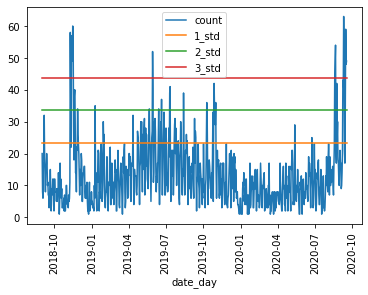

In [15]:
#Visualize time series and standard deviations
time_series.plot(x="date_day", y=["count", "1_std", "2_std", "3_std"], rot = 90)

In [16]:
#Filter to the events that were 3 standard deviations or more from the mean
key_events = time_series[time_series['count'] >= time_series['3_std']]

#
print("The number of 'days with key events' has been narrowed down to {}".format(key_events.shape[0]))
#May want to get days leading up to and after key events above


The number of 'days with key events' has been narrowed down to 14


### Build algorithm to highlight news from peaks 

Question 2 - Develop Algorithm to highlight important news, efficiently and succinctly

In [17]:
#filter data to the key events from #1

filt_df = pd.merge(docs_df, key_events[['date_day']],
                                    left_on='date_day',
                                    right_on='date_day',    
                                    how='inner')

In [18]:
#load spacy model
nlp =  spacy.load('en_core_web_lg')


In [19]:
#function to find numbers in text as this could point to subtantive events
def hasNumbers(inputString):
     return bool(re.search(r'\d', inputString))   
    

Note - The first approach will involve:
A) parsing through all content and extracting candidate event sentences that could contain succint and important information based on rules.
B) These candidate sentences will be cleaned and embedded using spacy
C) Sentences embeddings will be grouped by date and then clustered to identify sentences talking about the same events
D) Top sentences will be ordered by day and outputed 

In [82]:
#A) and B)

sent_vecs = {} #Will store all sentence embeddings
unique_days = set() #Unique days that actually had candidate event sentences

#Counter used to index df
counter = 0
for summary in tqdm(filt_df.summary):

    #Break up into iteratable sentences
    sentences = list(nlp(summary).sents)
    
    #For each sentence
    for i in range(len(sentences)):
        
        #clean data
        clean_space = ' '.join(sentences[i].text.split()).lower()
        clean_punc = re.sub(r'[^\w\s]', '', clean_space) 
        sent = nlp(clean_punc) #process using spacy
        
        ent_type = [e.label_ for e in sent.ents] #find event types
        
        ##rules to find candidate event sentences
                  
        # if hasNumbers(sentences[i].text) and 'GPE' in ent_type:
        if 'GPE' in ent_type and  hasNumbers(clean_punc):
            
            unique_days.add(filt_df.date_day.iloc[counter])   
            
            sent_vecs.update({(filt_df.id.iloc[counter], #0
                               filt_df.date.iloc[counter],     #1
                               filt_df.date_day.iloc[counter], #2
                               clean_punc,                     #3
                              sentences[i].text) :             #4                
                              sent.vector})     
        
    counter += 1
    
    

100%|██████████| 760/760 [00:31<00:00, 23.76it/s]


In [85]:
#C) and D)

all_output = pd.DataFrame([]) #will store extracted events

#for all unique peak days
for day in tqdm(list(unique_days)):

    to_cluster =[]
    sentences_clean = []
    sentences_raw = []
    time = []
    e_id = []
    for i in sent_vecs.keys():
        #if the sentence is from 'day'
        if i[2] == day:
            e_id.append(i[0])
            time.append(i[1])
            sentences_clean.append( i[3])
            sentences_raw.append( i[4]) 
            to_cluster.append(sent_vecs[i])
            
    
    x = np.array(to_cluster)
    
    n_classes = {}
    
    max_clusters = 0
    eps_pick = 0
    
    #Try different epsilon values to see which one gives me the highest number of clusters - aka more unique events
    for i in np.arange(0.001, .5, 0.002):
    
        dbscan = DBSCAN(eps = i, min_samples = 2, metric = 'cosine').fit(x)
        
        clust_num = len(pd.Series(dbscan.labels_).value_counts()) #number of clusters
        
        #Check if this is a 'better' epsilon
        if clust_num > max_clusters:
            max_clusters = clust_num
            eps_pick = i
        
        n_classes.update({i: clust_num})
        

    #Use the 'best' epsilon
    dbscan = DBSCAN(eps = eps_pick, min_samples = 2, metric = 'cosine').fit(x)
    
    #Dataframe with dbscan outputs
    db_scan_results = pd.DataFrame({'label': dbscan.labels_, 'sent': sentences_raw, 'id': e_id,
                            'embed': to_cluster,'time': time, 'top_sent': None})
    
    
    #join with other columns to have acess to the source information
    results = pd.merge(db_scan_results, filt_df[['sources', 'people', 'id', 'event_id',
                                             'organizations', 'locations', 'summary']], 
                                    left_on='id',
                                    right_on='id',    
                                    how='inner')
    
    #Empty dataframe to store top sentences
    final_results = pd.DataFrame([]) 
    
    #For each unique cluster, find the sentence that depicts the event
    ## best based on distance from the mean embedding vector
    
    for i in results.label.unique():
        #-1 indicates no cluster was found these
        if i != -1:
            tmp = copy.deepcopy(results)
            
            tmp = tmp[tmp['label'] == i].reset_index()
            
            #Calculate mean vector
            mean_vec = np.array(tmp['embed']).mean(axis = 0) 
            
            #Find the sentence with the closest distance to the mean vector
            index = pairwise_distances_argmin_min(np.array([mean_vec]), list((tmp['embed'])))[0][0]
            
            #Tag top sentence
            tmp['top_sent'] = np.where(tmp.index == index, True,  False)
            
            #Append top sentence from label to the compiled output
            final_results = final_results.append(tmp, ignore_index=True)
            
    
    #Sort and order based on time of the day
    final = final_results[final_results['top_sent'] == True].sort_values(by = ['time'])
    final['day'] = day
    
    #Append all model outputs
    all_output = all_output.append(final, ignore_index=True)

    
    

100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


### How are the outputs looking?

In [86]:
#Let's look at a couple of examples

df = all_output[['sent', 'time']][all_output['day'] == all_output['day'].min()] #Looking at the oldest event

for index, row in df.iterrows():
    print('----')
    print(row['time'])
    print(row['sent'])

----
2018-11-09T02:05:37Z
A state of emergency has been declared for Butte County due to the effects of the Camp Fire, which began around 6:30 a.m. Thursday and quickly spread, said the California Department of Forestry and Fire Protection, known as Cal Fire.
----
2018-11-09T02:05:37Z
About 3,300 students and staff members from Paradise's 11 schools were evacuated in buses and employees' cars to a center in Chico,
----
2018-11-09T16:26:11Z
Fire officials have issued evacuation notices for parts of Chico, a town of 93,000 people north of Sacramento.
----
2018-11-09T19:26:51Z
A burning sign is seen outside Paradise Skilled Nursing home during the Camp Fire in Paradise, California, US on November 8, 2018.
----
2018-11-09T19:26:51Z
A wildfire that moved so fast that firefighters couldn't hope to stop it quadrupled in size Friday after destroying several thousand buildings and leveling much of a Northern California town of nearly 30,000 people, authorities said.
----
2018-11-09T19:26:51Z
Th

In [87]:
df = all_output[['sent', 'time']][all_output['day'] == all_output['day'].max()] #Looking at the most recent event

for index, row in df.iterrows():
    print('----')
    print(row['time'])
    print(row['sent'])

----
2020-09-17T14:32:26Z
More than 200 B.C. firefighters and related personnel are heading to the U.S. to help battle extreme fire activity in Oregon.
----
2020-09-17T23:45:57Z
At least 36 people have died in the fires, which are ravaging parts of California, Oregon, and Washington State, and many others are missing.


### Join entities data provided 

In [88]:
#####Joining entities data

###Map people
    
people_dict = {}

for i in entities['people']:
    people_dict[i['id']] = i['display_person']


all_output['people_dec'] = all_output['people'].apply(lambda x: ','.join(map(str, x))) #convert list to strings

all_output['people_dec'] = all_output["people_dec"].replace(people_dict, regex=True) #replace with entities

#Now map locations

location_dict = {}
for i in entities['locations']:
    location_dict[i['id']] = json.dumps(i)

all_output['locations_dec'] = all_output['locations'].apply(lambda x: ','.join(map(str, x))) #convert list to strings

all_output['locations_dec'] = all_output["locations_dec"].replace(location_dict, regex=True) #replace with entities

#Need to map organization

In [89]:
#Let's look at it with the new entities

df = all_output[all_output['day'] == all_output['day'].min()] #Looking at the most recent event

for index, row in df.iterrows():
    print('-------')
    print(row['time'])
    print(row['sent'])
    print('People Involved: {}'.format(row['people_dec'].split(',')))
    
    for j in row['locations_dec'].split('},'):
        if j[-1] != "}":
            loc = json.loads(j+'}')
        else:
            loc = json.loads(j)
        print('--')
        print('Location: {}'.format(loc['name']))
        print('Latitude: {}'.format(loc['latitude']))
        print('Longitude: {}'.format(loc['longitude']))


-------
2018-11-09T02:05:37Z
A state of emergency has been declared for Butte County due to the effects of the Camp Fire, which began around 6:30 a.m. Thursday and quickly spread, said the California Department of Forestry and Fire Protection, known as Cal Fire.
People Involved: ['Josh Peete', 'John Gaddie', 'Morgan Mason', 'Tanah Clunies-Ross', 'Jillian Smalley', 'Allana Hall', 'Tim Taylor']
--
Location: Chico
Latitude: 39.72849
Longitude: -121.83748
--
Location: Oroville
Latitude: 39.51394
Longitude: -121.55776
--
Location: California
Latitude: nan
Longitude: nan
--
Location: Butte County
Latitude: nan
Longitude: nan
--
Location: Paradise
Latitude: 36.09719
Longitude: -115.14666
--
Location: Magalia
Latitude: 39.81211
Longitude: -121.57831
-------
2018-11-09T02:05:37Z
About 3,300 students and staff members from Paradise's 11 schools were evacuated in buses and employees' cars to a center in Chico,
People Involved: ['Josh Peete', 'John Gaddie', 'Morgan Mason', 'Tanah Clunies-Ross', 'J

In [90]:
#Get csv of model outputs
all_output.to_csv('model_output2.csv')

### Consume Information

Question 3 - Find interesting ways to show data. 

An R Shiny dashboard was created to facilitate consuming information in an efficient, seamless, and organized manner. In addition to organizing events chronologically, a user can interact with the dashboard and understand where events have transpired over time.


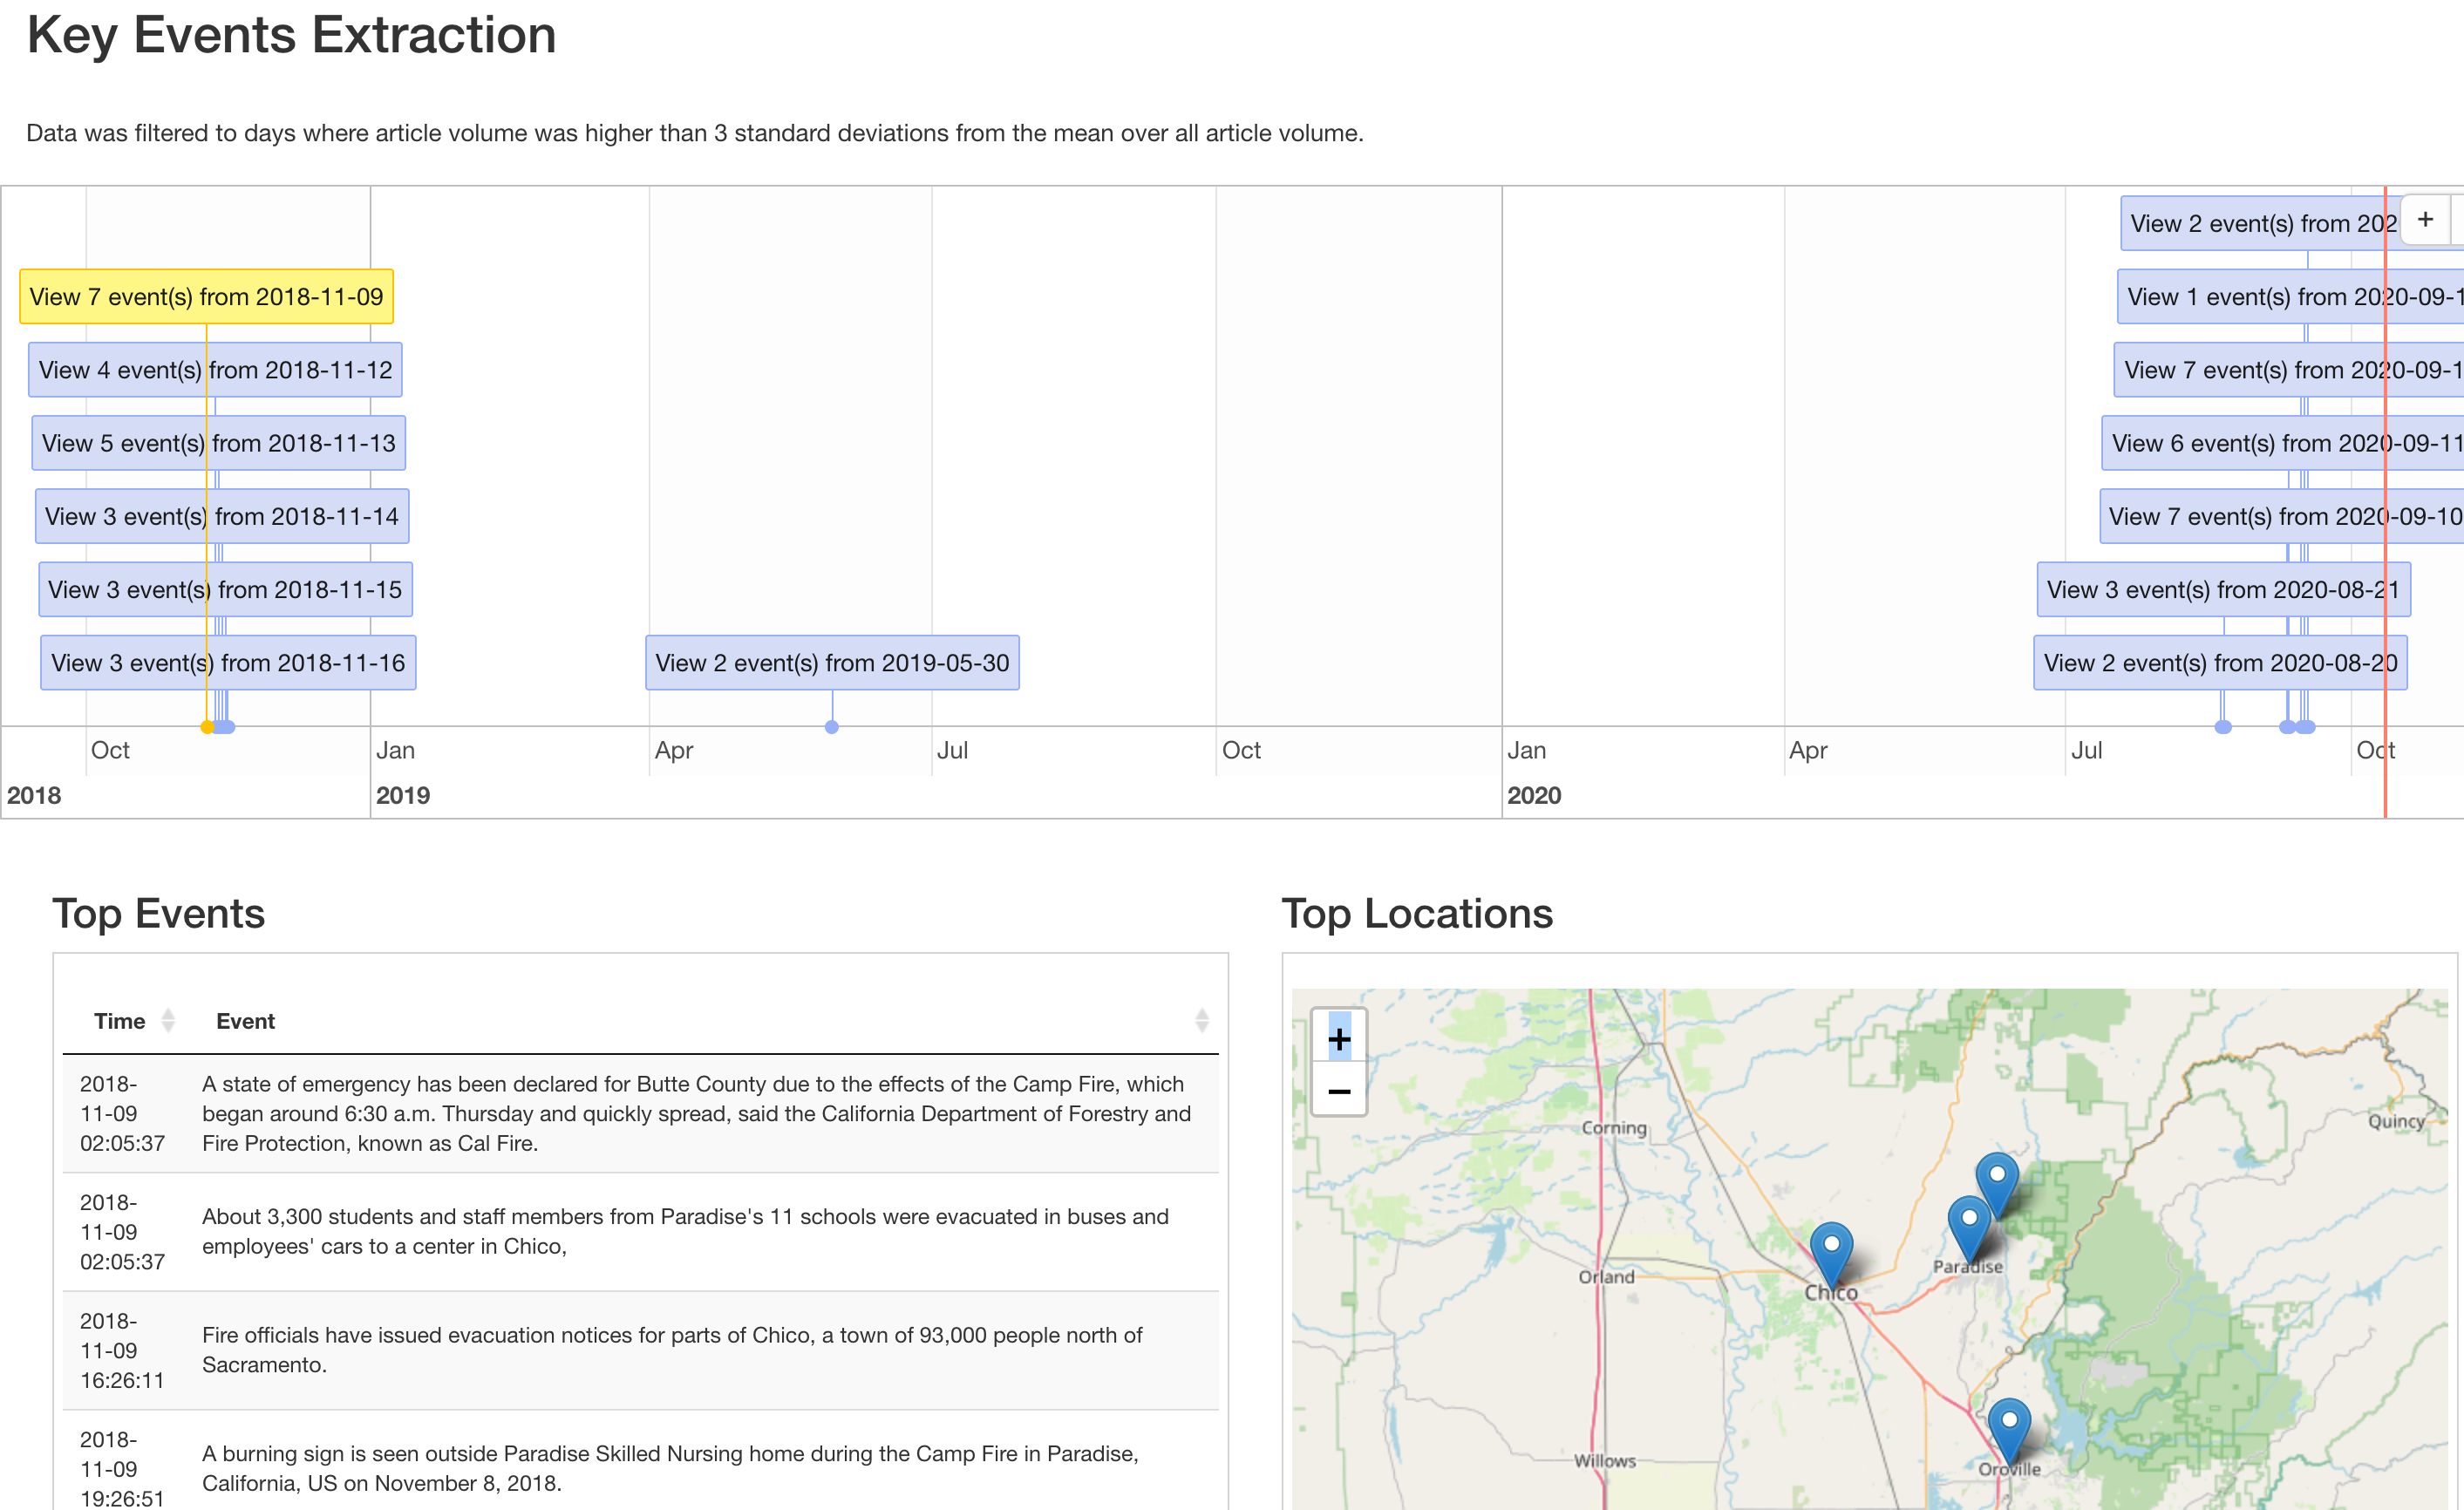